# Final model

### Resources

- https://geemap.org/notebooks/46_local_rf_training/

## Setup

In [1]:
from google.colab import drive
import os
import time
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import ee
import geemap
from geemap import ml
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/land_cover_classification_kaza

/content/drive/MyDrive/land_cover_classification_kaza


In [4]:
user_id = 'ee-alexvmt'
asset_name = 'mufunta_random_forest'

In [5]:
ee.Authenticate()
ee.Initialize(project=user_id)

## Load train and test set

In [6]:
train = pd.read_csv('data/train.csv')
train

,B11_dry,B11_rainy,B12_dry,B12_rainy,B2_dry,B2_rainy,B3_dry,B3_rainy,B4_dry,B4_rainy,...,NDVI_rainy,NDWI_MCF_rainy,NDWI_GAO_rainy,SAVI_rainy,EVI_rainy,NDVI_dry,NDWI_MCF_dry,NDWI_GAO_dry,SAVI_dry,EVI_dry
0,1993.000000,2181.0,1200.0,1565.0,518.375000,612.0,692.500000,792.0,804.0,824.0,...,0.528334,-0.542461,0.260921,0.792388,1.525620,0.473592,-0.529418,0.304482,0.710272,1.134514
1,1877.000000,1936.0,1243.0,947.0,405.000000,335.0,529.000000,556.0,555.0,336.0,...,0.755459,-0.625337,0.436142,1.132982,2.708062,0.522581,-0.539800,0.174909,0.783702,1.472014
2,2244.500000,2038.0,1338.8,1057.0,478.000000,343.0,696.000000,612.0,739.5,460.0,...,0.727488,-0.653061,0.467908,1.091071,1.977774,0.554048,-0.574702,0.316206,0.830947,1.339286
3,1872.500000,1748.0,1225.5,928.0,386.500000,294.0,522.000000,407.0,560.5,309.0,...,0.728113,-0.656685,0.358230,1.091929,2.563507,0.514614,-0.540291,0.175996,0.771753,1.341876
4,2081.000000,1990.0,1229.0,996.0,433.000000,343.0,608.666667,602.0,628.0,398.0,...,0.742395,-0.634487,0.459870,1.113412,2.286227,0.543273,-0.554199,0.266488,0.814761,1.412900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,3092.666667,3232.0,2524.5,2754.0,866.500000,1162.0,1096.000000,1492.0,1484.0,1278.0,...,0.430735,-0.365646,0.076768,0.646031,2.232225,0.208674,-0.348136,-0.053814,0.312969,0.418725
3301,3586.000000,3501.0,3187.5,2601.0,1168.000000,1090.0,1326.000000,1250.0,2012.0,2154.0,...,0.163170,-0.410933,0.070241,0.244731,0.271178,0.130886,-0.327586,-0.098097,0.196307,0.255438
3302,3474.400000,2904.0,2970.5,2308.0,1122.000000,1102.0,1458.000000,1466.0,1848.0,1642.0,...,0.258356,-0.310442,0.093836,0.387490,0.653864,0.185365,-0.296841,-0.049739,0.278017,0.392038
3303,3447.000000,2056.0,3303.0,1414.0,1203.333333,576.0,1410.000000,784.0,1806.0,699.5,...,0.515162,-0.472054,0.214444,0.772609,1.800509,0.161560,-0.279141,-0.137984,0.242312,0.403338


In [7]:
X_train = train.drop(['LC_Nr', 'LC_Out', 'Landcover'], axis=1)
X_train

,B11_dry,B11_rainy,B12_dry,B12_rainy,B2_dry,B2_rainy,B3_dry,B3_rainy,B4_dry,B4_rainy,...,NDVI_rainy,NDWI_MCF_rainy,NDWI_GAO_rainy,SAVI_rainy,EVI_rainy,NDVI_dry,NDWI_MCF_dry,NDWI_GAO_dry,SAVI_dry,EVI_dry
0,1993.000000,2181.0,1200.0,1565.0,518.375000,612.0,692.500000,792.0,804.0,824.0,...,0.528334,-0.542461,0.260921,0.792388,1.525620,0.473592,-0.529418,0.304482,0.710272,1.134514
1,1877.000000,1936.0,1243.0,947.0,405.000000,335.0,529.000000,556.0,555.0,336.0,...,0.755459,-0.625337,0.436142,1.132982,2.708062,0.522581,-0.539800,0.174909,0.783702,1.472014
2,2244.500000,2038.0,1338.8,1057.0,478.000000,343.0,696.000000,612.0,739.5,460.0,...,0.727488,-0.653061,0.467908,1.091071,1.977774,0.554048,-0.574702,0.316206,0.830947,1.339286
3,1872.500000,1748.0,1225.5,928.0,386.500000,294.0,522.000000,407.0,560.5,309.0,...,0.728113,-0.656685,0.358230,1.091929,2.563507,0.514614,-0.540291,0.175996,0.771753,1.341876
4,2081.000000,1990.0,1229.0,996.0,433.000000,343.0,608.666667,602.0,628.0,398.0,...,0.742395,-0.634487,0.459870,1.113412,2.286227,0.543273,-0.554199,0.266488,0.814761,1.412900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,3092.666667,3232.0,2524.5,2754.0,866.500000,1162.0,1096.000000,1492.0,1484.0,1278.0,...,0.430735,-0.365646,0.076768,0.646031,2.232225,0.208674,-0.348136,-0.053814,0.312969,0.418725
3301,3586.000000,3501.0,3187.5,2601.0,1168.000000,1090.0,1326.000000,1250.0,2012.0,2154.0,...,0.163170,-0.410933,0.070241,0.244731,0.271178,0.130886,-0.327586,-0.098097,0.196307,0.255438
3302,3474.400000,2904.0,2970.5,2308.0,1122.000000,1102.0,1458.000000,1466.0,1848.0,1642.0,...,0.258356,-0.310442,0.093836,0.387490,0.653864,0.185365,-0.296841,-0.049739,0.278017,0.392038
3303,3447.000000,2056.0,3303.0,1414.0,1203.333333,576.0,1410.000000,784.0,1806.0,699.5,...,0.515162,-0.472054,0.214444,0.772609,1.800509,0.161560,-0.279141,-0.137984,0.242312,0.403338


In [8]:
y_train = train['LC_Nr']
y_train

0       7
1       7
2       7
3       7
4       7
       ..
3300    3
3301    3
3302    3
3303    3
3304    3
Name: LC_Nr, Length: 3305, dtype: int64

In [9]:
test = pd.read_csv('data/test.csv')
test

,B11_dry,B11_rainy,B12_dry,B12_rainy,B2_dry,B2_rainy,B3_dry,B3_rainy,B4_dry,B4_rainy,...,NDVI_rainy,NDWI_MCF_rainy,NDWI_GAO_rainy,SAVI_rainy,EVI_rainy,NDVI_dry,NDWI_MCF_dry,NDWI_GAO_dry,SAVI_dry,EVI_dry
0,1466.250000,1610.0,747.800000,792.0,308.909091,325.0,455.000000,497.5,372.400000,310.0,...,0.765595,-0.648720,0.493444,1.148176,2.878874,0.662551,-0.602577,0.420882,0.993602,2.085102
1,1355.000000,1421.0,657.000000,600.0,316.500000,228.0,447.000000,362.0,367.000000,224.0,...,0.814646,-0.716634,0.570354,1.221717,2.692834,0.685586,-0.629737,0.499333,1.028158,2.226938
2,1879.500000,1911.0,1113.500000,935.0,390.000000,311.0,536.000000,539.0,563.666667,395.0,...,0.724451,-0.641979,0.451130,1.086486,2.068313,0.514429,-0.532694,0.224447,0.771478,1.347398
3,1833.333333,1832.0,1062.000000,869.0,382.000000,304.0,531.333333,589.0,546.000000,309.0,...,0.795296,-0.642922,0.514389,1.192747,2.626915,0.563433,-0.572654,0.296067,0.844980,1.488313
4,1906.142857,1685.0,1134.166667,934.0,399.400000,327.0,560.666667,532.0,654.142857,402.0,...,0.683962,-0.602094,0.392718,1.025742,2.068966,0.462085,-0.520525,0.221084,0.692985,1.037397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78316,2897.000000,3235.0,2883.000000,3290.0,961.333333,1346.0,1237.000000,1580.0,1584.000000,1932.0,...,0.062136,-0.161359,-0.201168,0.093193,0.173630,0.082271,-0.203221,-0.213639,0.123389,0.170550
78317,3748.500000,2491.0,3817.500000,1922.5,1204.000000,830.0,1412.000000,1061.5,1762.000000,1065.0,...,0.365316,-0.366741,0.087457,0.547892,1.247456,0.159752,-0.265349,-0.221698,0.239599,0.421384
78318,3840.000000,2655.5,3858.500000,2058.5,1327.000000,807.0,1559.000000,1053.0,1938.000000,1028.0,...,0.404058,-0.393957,0.081129,0.605999,1.372858,0.154081,-0.258149,-0.186774,0.231097,0.408518
78319,3790.000000,3933.0,3551.000000,3485.0,1240.000000,1660.0,1376.000000,1972.0,1724.000000,2398.0,...,0.137100,-0.231489,-0.048909,0.205631,0.373603,0.194957,-0.300635,-0.162357,0.292401,0.579218


In [10]:
X_test = test.drop(['LC_Nr', 'LC_Out', 'Landcover'], axis=1)
X_test

,B11_dry,B11_rainy,B12_dry,B12_rainy,B2_dry,B2_rainy,B3_dry,B3_rainy,B4_dry,B4_rainy,...,NDVI_rainy,NDWI_MCF_rainy,NDWI_GAO_rainy,SAVI_rainy,EVI_rainy,NDVI_dry,NDWI_MCF_dry,NDWI_GAO_dry,SAVI_dry,EVI_dry
0,1466.250000,1610.0,747.800000,792.0,308.909091,325.0,455.000000,497.5,372.400000,310.0,...,0.765595,-0.648720,0.493444,1.148176,2.878874,0.662551,-0.602577,0.420882,0.993602,2.085102
1,1355.000000,1421.0,657.000000,600.0,316.500000,228.0,447.000000,362.0,367.000000,224.0,...,0.814646,-0.716634,0.570354,1.221717,2.692834,0.685586,-0.629737,0.499333,1.028158,2.226938
2,1879.500000,1911.0,1113.500000,935.0,390.000000,311.0,536.000000,539.0,563.666667,395.0,...,0.724451,-0.641979,0.451130,1.086486,2.068313,0.514429,-0.532694,0.224447,0.771478,1.347398
3,1833.333333,1832.0,1062.000000,869.0,382.000000,304.0,531.333333,589.0,546.000000,309.0,...,0.795296,-0.642922,0.514389,1.192747,2.626915,0.563433,-0.572654,0.296067,0.844980,1.488313
4,1906.142857,1685.0,1134.166667,934.0,399.400000,327.0,560.666667,532.0,654.142857,402.0,...,0.683962,-0.602094,0.392718,1.025742,2.068966,0.462085,-0.520525,0.221084,0.692985,1.037397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78316,2897.000000,3235.0,2883.000000,3290.0,961.333333,1346.0,1237.000000,1580.0,1584.000000,1932.0,...,0.062136,-0.161359,-0.201168,0.093193,0.173630,0.082271,-0.203221,-0.213639,0.123389,0.170550
78317,3748.500000,2491.0,3817.500000,1922.5,1204.000000,830.0,1412.000000,1061.5,1762.000000,1065.0,...,0.365316,-0.366741,0.087457,0.547892,1.247456,0.159752,-0.265349,-0.221698,0.239599,0.421384
78318,3840.000000,2655.5,3858.500000,2058.5,1327.000000,807.0,1559.000000,1053.0,1938.000000,1028.0,...,0.404058,-0.393957,0.081129,0.605999,1.372858,0.154081,-0.258149,-0.186774,0.231097,0.408518
78319,3790.000000,3933.0,3551.000000,3485.0,1240.000000,1660.0,1376.000000,1972.0,1724.000000,2398.0,...,0.137100,-0.231489,-0.048909,0.205631,0.373603,0.194957,-0.300635,-0.162357,0.292401,0.579218


In [11]:
y_test = test['LC_Nr']
y_test

0        7
1        7
2        7
3        7
4        7
        ..
78316    3
78317    3
78318    3
78319    3
78320    3
Name: LC_Nr, Length: 78321, dtype: int64

## Train random forest with default hyperparameters

In [12]:
rf_default = RandomForestClassifier()

In [13]:
rf_default.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
y_train_pred = rf_default.predict(X_train)
y_test_pred = rf_default.predict(X_test)

## Evaluation

### Train set classification metrics

In [15]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_train, y_train_pred)))

Accuracy: 1.0000


In [16]:
print('Precision: {:0.4f}'.format(precision_score(y_train, y_train_pred, average='macro')))

Precision: 1.0000


In [17]:
print('Recall: {:0.4f}'.format(recall_score(y_train, y_train_pred, average='macro')))

Recall: 1.0000


In [18]:
print('F1-Score: {:0.4f}'.format(f1_score(y_train, y_train_pred, average='macro')))

F1-Score: 1.0000


In [19]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       263
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500

    accuracy                           1.00      3305
   macro avg       1.00      1.00      1.00      3305
weighted avg       1.00      1.00      1.00      3305



In [20]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[263,   0,   0,   0,   0,   0,   0,   0],
       [  0, 332,   0,   0,   0,   0,   0,   0],
       [  0,   0, 210,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500]])

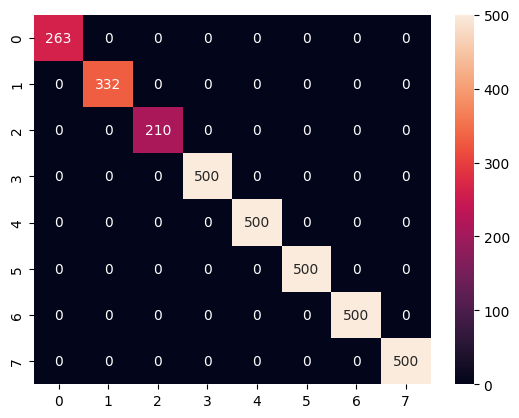

In [21]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Test set classifiction metrics

In [22]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.8895


In [23]:
print('Precision: {:0.4f}'.format(precision_score(y_test, y_test_pred, average='macro')))

Precision: 0.7207


In [24]:
print('Recall: {:0.4f}'.format(recall_score(y_test, y_test_pred, average='macro')))

Recall: 0.8910


In [25]:
print('F1-Score: {:0.4f}'.format(f1_score(y_test, y_test_pred, average='macro')))

F1-Score: 0.7598


In [26]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.84      0.99      0.91       113
           2       0.12      0.94      0.22       143
           3       0.63      0.82      0.71        90
           4       0.99      0.90      0.94     17628
           5       0.65      0.87      0.74      3248
           6       0.61      0.81      0.70      8266
           7       0.96      0.90      0.93     35183
           8       0.97      0.90      0.93     13650

    accuracy                           0.89     78321
   macro avg       0.72      0.89      0.76     78321
weighted avg       0.92      0.89      0.90     78321



In [27]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[  112,     0,     0,     0,     0,     0,     0,     1],
       [    0,   134,     0,     8,     1,     0,     0,     0],
       [    0,     7,    74,     7,     1,     1,     0,     0],
       [    0,   902,    41, 15820,   259,   460,   130,    16],
       [    0,    29,     0,    19,  2825,   172,    10,   193],
       [    0,    27,     0,    87,   425,  6697,  1000,    30],
       [    0,     0,     0,     0,    15,  3311, 31741,   116],
       [   22,     0,     3,    42,   842,   296,   182, 12263]])

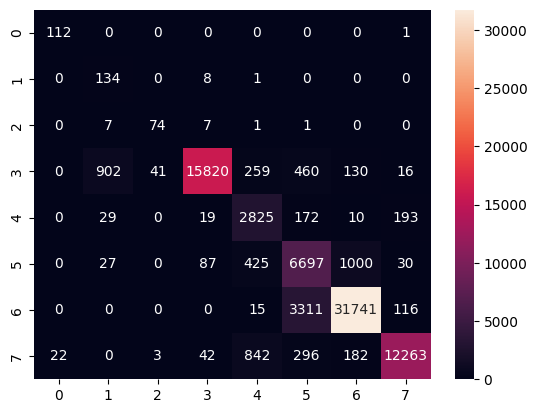

In [28]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Train random forest with optimized hyperparameters

Get optimized hyperparameters from notebook called `optimization.ipynb`.

In [29]:
rf_optimized = RandomForestClassifier(bootstrap=False, max_features=4, min_samples_split=3,
                           n_estimators=512, n_jobs=1, random_state=1,
                           warm_start=True)

In [30]:
rf_optimized.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features=4, min_samples_split=3,
                       n_estimators=512, n_jobs=1, random_state=1,
                       warm_start=True)

In [31]:
y_train_pred = rf_optimized.predict(X_train)
y_test_pred = rf_optimized.predict(X_test)

## Evaluation

### Train set classification metrics

In [32]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_train, y_train_pred)))

Accuracy: 1.0000


In [33]:
print('Precision: {:0.4f}'.format(precision_score(y_train, y_train_pred, average='macro')))

Precision: 1.0000


In [34]:
print('Recall: {:0.4f}'.format(recall_score(y_train, y_train_pred, average='macro')))

Recall: 1.0000


In [35]:
print('F1-Score: {:0.4f}'.format(f1_score(y_train, y_train_pred, average='macro')))

F1-Score: 1.0000


In [36]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       263
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00       210
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500

    accuracy                           1.00      3305
   macro avg       1.00      1.00      1.00      3305
weighted avg       1.00      1.00      1.00      3305



In [37]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[263,   0,   0,   0,   0,   0,   0,   0],
       [  0, 332,   0,   0,   0,   0,   0,   0],
       [  0,   0, 210,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0],
       [  0,   0,   0,   0, 500,   0,   0,   0],
       [  0,   0,   0,   0,   0, 500,   0,   0],
       [  0,   0,   0,   0,   0,   0, 500,   0],
       [  0,   0,   0,   0,   0,   0,   0, 500]])

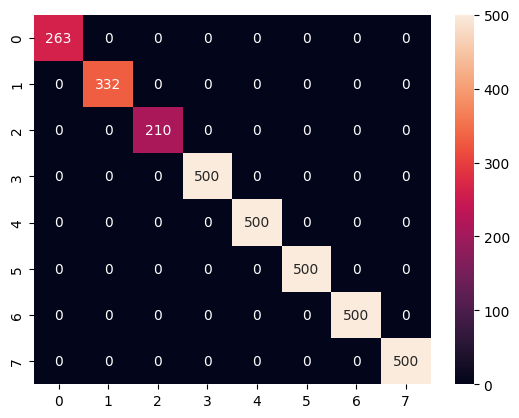

In [38]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Test set classifiction metrics

In [39]:
print('Accuracy: {:0.4f}'.format(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.8979


In [40]:
print('Precision: {:0.4f}'.format(precision_score(y_test, y_test_pred, average='macro')))

Precision: 0.7383


In [41]:
print('Recall: {:0.4f}'.format(recall_score(y_test, y_test_pred, average='macro')))

Recall: 0.9031


In [42]:
print('F1-Score: {:0.4f}'.format(f1_score(y_test, y_test_pred, average='macro')))

F1-Score: 0.7793


In [43]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.85      1.00      0.92       113
           2       0.15      0.94      0.26       143
           3       0.68      0.87      0.76        90
           4       0.99      0.91      0.95     17628
           5       0.68      0.87      0.76      3248
           6       0.63      0.82      0.71      8266
           7       0.96      0.91      0.93     35183
           8       0.97      0.91      0.94     13650

    accuracy                           0.90     78321
   macro avg       0.74      0.90      0.78     78321
weighted avg       0.92      0.90      0.91     78321



In [44]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[  113,     0,     0,     0,     0,     0,     0,     0],
       [    0,   134,     0,     7,     2,     0,     0,     0],
       [    0,     5,    78,     6,     1,     0,     0,     0],
       [    0,   700,    36, 16080,   228,   442,   127,    15],
       [    0,    25,     0,    22,  2830,   174,     9,   188],
       [    0,    34,     0,    80,   365,  6789,   967,    31],
       [    0,     0,     0,     0,    15,  3162, 31867,   139],
       [   20,     0,     1,    41,   719,   274,   164, 12431]])

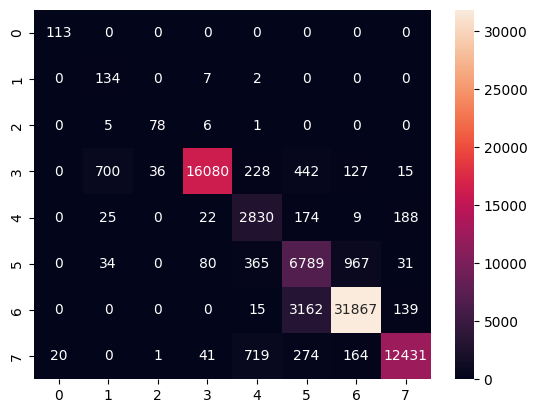

In [45]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Convert sklearn classifier object to a list of strings

In [ ]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
start_time = time.perf_counter()
trees = ml.rf_to_strings(rf_default, X_train.columns)
end_time = time.perf_counter()
run_time = round((end_time - start_time) / 60, 2)
print('Run time: {} minutes.'.format(run_time))

Run time: 0.98 minutes.


In [ ]:
# print the first tree to see the result
print(trees[0])

1) root 2075 9999 9999 (112.54864990845869)
  2) B12_dry <= 1341.875000 2075 0.8646 7
    4) B8A_rainy <= 2019.000000 560 0.6309 7
      8) B8A_dry <= 953.416656 217 0.2796 1
        16) B8_dry <= 610.125000 166 0.0000 1 *
        17) B8_dry > 610.125000 180 0.0594 1
          34) B12_dry <= 873.833344 7 0.0000 1 *
          35) B12_dry > 873.833344 7 0.0000 8 *
      9) B8A_dry > 953.416656 217 0.2796 1
        18) B6_dry <= 941.500000 37 0.2325 8
          36) B5_dry <= 727.437500 4 0.0000 1 *
          37) B5_dry > 727.437500 5 0.0000 8 *
        19) B6_dry > 941.500000 37 0.2325 8
          38) NDWI_MCF_dry <= -0.548434 2 0.0000 7 *
          39) NDWI_MCF_dry > -0.548434 26 0.0000 8 *
    5) B8A_rainy > 2019.000000 560 0.6309 7
      10) EVI_dry <= 1.049378 343 0.3290 7
        20) SAVI_dry <= 0.625388 19 0.0000 8 *
        21) SAVI_dry > 0.625388 39 0.6199 8
          42) SAVI_rainy <= 0.982131 20 0.5491 6
            84) B6_rainy <= 1920.750000 1 0.0000 8 *
            85) B6_rai

In [ ]:
print(trees[1])

1) root 2085 9999 9999 (121.76780322763884)
  2) B2_dry <= 643.750000 2085 0.8646 4
    4) EVI_dry <= -0.448979 152 0.0000 1 *
    5) EVI_dry > -0.448979 1382 0.8051 8
      10) B7_rainy <= 1903.000000 1230 0.7709 8
        20) EVI_dry <= 1.523843 269 0.2899 8
          40) B8_rainy <= 1624.000000 257 0.2202 8
            80) B12_dry <= 859.333344 2 0.0000 1 *
            81) B12_dry > 859.333344 168 0.0000 8 *
          41) B8_rainy > 1624.000000 257 0.2202 8
            82) B4_dry <= 697.500000 87 0.4561 8
              164) B12_dry <= 1024.000000 1 0.0000 1 *
              165) B12_dry > 1024.000000 26 0.1189 8
                330) B6_rainy <= 1421.000000 25 0.0425 8
                  660) B12_dry <= 1447.000000 4 0.0000 8 *
                  661) B12_dry > 1447.000000 1 0.0000 5 *
                331) B6_rainy > 1421.000000 20 0.0000 8 *
            83) B4_dry > 697.500000 87 0.4561 8
              166) B5_rainy <= 1069.500000 61 0.5108 8
                332) B8A_rainy <= 1812.5000

In [ ]:
# number of trees we converted should equal the number of trees we defined for the model
n_trees = 100
len(trees) == n_trees

True

## Convert sklearn classifier to GEE classifier

At this point you can take the list of strings and save them locally to avoid training again. However, we want to use the model with EE so we need to create an ee.Classifier and persist the data on ee for best results.

In [ ]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

In [ ]:
ee_classifier.getInfo()

Output hidden; open in https://colab.research.google.com to view.

## Save trees to the cloud

Now we have the strings in a format that ee can use, we want to save it for later use. There is a function to export a list of tree strings to a feature collection.

In [ ]:
# specify asset id where to save trees
asset_id = 'projects/' + user_id + '/assets/' + asset_name + '_trees'
asset_id

'projects/ee-alexvmt/assets/mufunta_random_forest_trees'

In [ ]:
# kick off an export process so it will be saved to the ee asset
ml.export_trees_to_fc(trees, asset_id)

# this will kick off an export task, so wait a few minutes before moving on
# check progress here: https://code.earthengine.google.com/tasks

In [ ]:
# save ee classifier to be used in ee directly
classifier_asset_id = 'projects/' + user_id + '/assets/' + asset_name + '_classifier'
task = ee.batch.Export.classifier.toAsset(
    ee_classifier, 'saved classifier', classifier_asset_id
)
task.start()

## Save trees locally

In [ ]:
out_csv = os.path.expanduser('models/trees.csv')
ml.trees_to_csv(trees, out_csv)